# Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

2022-08-05 16:24:28.315912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 16:24:28.315948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Download the dataset

In [ ]:
#!kaggle datasets download -d drizasazanitaisa/dyslexia-handwriting-dataset --unzip

# Preparing the data

In [ ]:
img_height = 32
img_width = 32

NUM_TRAIN_IMGS = 151649
NUM_TEST_IMGS = 56723

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "new_folder/Gambo/Train",
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=NUM_TRAIN_IMGS,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    "new_folder/Gambo/Test",
    labels="inferred",
    label_mode="int", 
    color_mode="grayscale",
    batch_size= NUM_TEST_IMGS,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

Found 151649 files belonging to 3 classes.
2022-08-05 16:24:54.372198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-05 16:24:54.372236: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-05 16:24:54.372264: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-5f67ef5c-e620-4a01-8df6-6115e44c5ac0): /proc/driver/nvidia/version does not exist
2022-08-05 16:24:54.372656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Found 56723 files belonging to 3 

In [ ]:
class_names = ds_train.class_names
print(class_names)

['Corrected', 'Normal', 'Reversal']


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.1)
    ]
)

In [ ]:
train_images = np.array([])
train_labels = np.array([])
test_images = np.array([])
test_labels = np.array([])

for tr_images, tr_labels in ds_train.take(1):
    tr_augmented_images = tr_images
    train_images = tr_augmented_images.numpy().reshape((NUM_TRAIN_IMGS, img_height, img_width, 1))
    train_labels = tr_labels.numpy()
    print("Done")

for t_images, t_labels in ds_test.take(1):
    t_augmented_images = t_images
    test_images = t_augmented_images.numpy().reshape((NUM_TEST_IMGS, img_height, img_width, 1))
    test_labels = t_labels.numpy()
    print("Done")

train_images = train_images / 255
test_images = test_images / 255

2022-08-05 16:25:31.821290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 29518 of 1213192
2022-08-05 16:25:41.821752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 57283 of 1213192
2022-08-05 16:25:51.821320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 83920 of 1213192
2022-08-05 16:26:01.821307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 102013 of 1213192
2022-08-05 16:26:11.823508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 121456 of 1213192
2022-08-05 16:26:21.823523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 138800 of 1213192
2022-08-05 16:26:29.237266: I tensorflow/core/kernels/data/shuffle_datase

In [ ]:
# Code to turn all white-bg + black-txt --> black-bg and white-txt
# index = np.where(train_images[:,0,0,0] == 1)
# train_images[index] = 1 - train_images[index]
# plt.imshow(train_images[0], cmap = "gray")
# index = np.where(test_images[:,0,0,0] == 1)
# test_images[index] = 1 - test_images[index]
# plt.imshow(test_images[0], cmap = "gray")

# Code to turn all black-bg and white-txt --> white-bg + black-txt
index = np.where(train_images[:,0,0,0] != 1)
train_images[index] = 1 - train_images[index]
# plt.imshow(train_images[1], cmap = "gray")
# plt.axis("off")
index = np.where(test_images[:,0,0,0] != 1)
test_images[index] = 1 - test_images[index]


# Data Visualization 

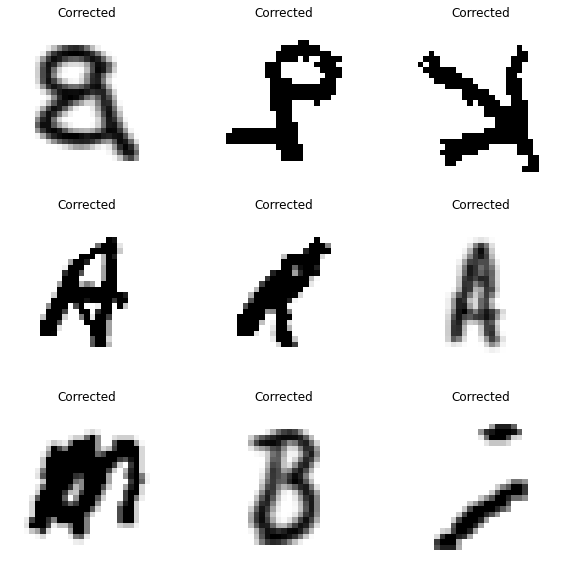

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i], cmap = "gray")
    plt.title(class_names[int(np.argmax(train_labels[i]))])
    plt.axis("off")

# Undersampling

In [ ]:
corr = train_images[train_labels == 0]
norm = train_images[train_labels == 1]
reve = train_images[train_labels == 2]

index = np.sort(np.random.choice(np.where(train_labels == 0)[0], size = len(norm)))
corr = train_images[index]
corr_labels = train_labels[index]

index = np.sort(np.random.choice(np.where(train_labels == 2)[0], size = len(norm)))
reve = train_images[index]
reve_labels = train_labels[index]

train_images = np.concatenate((corr, norm, reve))
train_labels = np.concatenate((corr_labels, train_labels[train_labels == 1], reve_labels))

# Models

In [ ]:
# ## For Transfer learning
# if train_images.shape[-1] == 1:
#     train_images = np.repeat(train_images, 3, -1)
# if test_images.shape[-1] == 1:
#     test_images = np.repeat(test_images, 3, -1)

p_train_images, val_images, p_train_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.25)

p_train_labels = tf.keras.utils.to_categorical(p_train_labels, 3).astype(np.float32)
val_labels = tf.keras.utils.to_categorical(val_labels, 3).astype(np.float32)
test_labels = tf.keras.utils.to_categorical(test_labels, 3).astype(np.float32)

## CNN

In [ ]:
model = keras.Sequential(
    [
        layers.Input((p_train_images.shape[1:])),
        layers.Conv2D(32, 3, activation = 'relu', padding="same"),
        layers.Conv2D(16, 3, activation = 'relu', padding="same"),
        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dropout(rate = 0.2),
        layers.Dense(3, activation='softmax'),
    ]
)

## Random Forest

In [ ]:
p_train_images = np.squeeze(p_train_images).reshape(len(p_train_images), img_height * img_width)
val_images = np.squeeze(val_images).reshape(len(val_images), img_height * img_width)
test_images = np.squeeze(test_images).reshape(len(test_images), img_height * img_width)

random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=2)
random_forest.fit(p_train_images, p_train_labels)
print("Done!")

KeyboardInterrupt: 

In [ ]:
train_pred=random_forest.predict(p_train_images)
print("Training Accuracy is ", accuracy_score(p_train_labels, train_pred) * 100)
val_pred=random_forest.predict(val_images)
print("Validation Accuracy is ", accuracy_score(val_labels, val_pred) * 100)
test_pred=random_forest.predict(test_images)
print("Test Accuracy is ", accuracy_score(test_labels, test_pred) * 100)

Training Accuracy is  83.4089470352395
Validation Accuracy is  81.01970300424657
Test Accuracy is  67.64099219011689


## Transfer Learning

In [ ]:
base = tf.keras.applications.InceptionV3(input_shape=p_train_images.shape[1:],
                                            include_top=False,
                                            weights='imagenet')
#base = tf.keras.applications.vgg16.VGG16(input_shape=p_train_images.shape[1:],
                                            include_top=False,
                                            weights='imagenet')
base.trainable = True

num_classes = 3

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer1 = tf.keras.layers.Dense(64, activation='relu')
prediction_layer2 = tf.keras.layers.Dense(num_classes, activation='softmax')
#VGG16 Layers
prediction_layer1 = tf.keras.layers.Dense(128, activation='relu')
drop = tf.keras.layers.Dropout(0.6)
prediction_layer2 = tf.keras.layers.Dense(64, activation='relu')
prediction_layer3 = tf.keras.layers.Dense(num_classes, activation='softmax')

model = tf.keras.Sequential([
    base,
    global_average_layer,
    prediction_layer1,
    prediction_layer2
])

87910968/87910968 [==============================] - 1s 0us/step


## LeNet-5

In [ ]:
model = keras.Sequential(
    [
        layers.Input((32, 32, 1)),
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(3, activation = 'softmax')
    ]
)

In [ ]:
base_learning_rate = 0.001
loss_func = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate)
model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)              

# Training

In [ ]:
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()
    
history = model.fit(p_train_images, p_train_labels, 
        epochs=5, # number of epochs (passes through data during training)
        batch_size= 64, # number of points to consider in each optimizer iteration
        callbacks = [garbage_collect_callback()],
        validation_data=(val_images, val_labels), #data to use for validation
        verbose=1) #will print information about optimization process

Epoch 1/5
1383/1383 [==============================] - 10s 7ms/step - loss: 0.4154 - accuracy: 0.8335 - val_loss: 0.2483 - val_accuracy: 0.9082
Epoch 2/5
1383/1383 [==============================] - 10s 7ms/step - loss: 0.1962 - accuracy: 0.9254 - val_loss: 0.1588 - val_accuracy: 0.9397
Epoch 3/5
1383/1383 [==============================] - 9s 7ms/step - loss: 0.1412 - accuracy: 0.9462 - val_loss: 0.1155 - val_accuracy: 0.9558
Epoch 4/5
1383/1383 [==============================] - 9s 6ms/step - loss: 0.1100 - accuracy: 0.9586 - val_loss: 0.1361 - val_accuracy: 0.9500
Epoch 5/5
1383/1383 [==============================] - 9s 7ms/step - loss: 0.0899 - accuracy: 0.9668 - val_loss: 0.1137 - val_accuracy: 0.9574


In [ ]:
test_pred = model.predict(test_images)
scores = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Model Loss: {scores[0]:.3f}, Model Accuracy: {scores[1]:.3f}')

1773/1773 [==============================] - 4s 2ms/step
Model Loss: 0.700, Model Accuracy: 0.830


# Evaluation

## Confusion Matrix

/tmp/ipykernel_97/3006982756.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels, fontsize=16)
/tmp/ipykernel_97/3006982756.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels, fontsize=16)


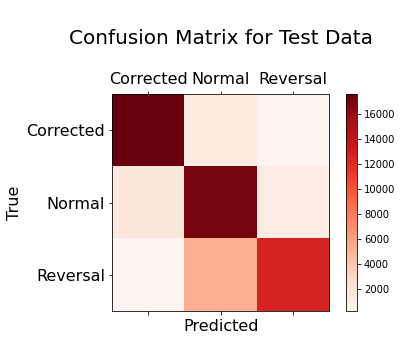

In [ ]:
test_labels_unonehot = np.argmax(test_labels, axis=1)
test_pred_unonehot = np.argmax(test_pred, axis=1)

cm = confusion_matrix(test_labels_unonehot, test_pred_unonehot)

def plot_cmatrix(cm,labels,title='Confusion Matrix'):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap='Reds')
  plt.title('\n'+title+'\n', fontsize=20)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels, fontsize=16)
  ax.set_yticklabels([''] + labels, fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.show()

plot_cmatrix(cm, class_names, 'Confusion Matrix for Test Data')

/tmp/ipykernel_97/3006982756.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels, fontsize=16)
/tmp/ipykernel_97/3006982756.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels, fontsize=16)


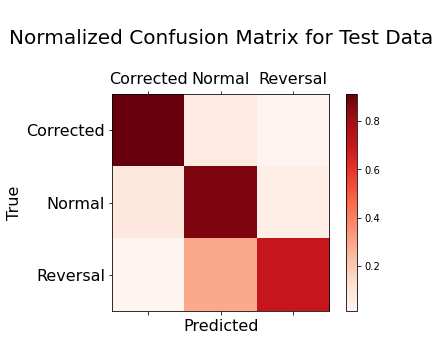

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_cmatrix(cm_norm, class_names,title='Normalized Confusion Matrix for Test Data')

## AUC and ROC

In [ ]:
auc = roc_auc_score(test_labels, test_pred, multi_class='ovr')
print(f"AUC: {auc}")

AUC: 0.9384053178847872


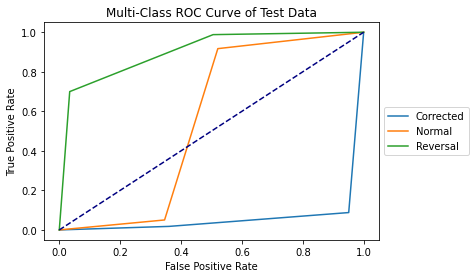

In [ ]:
for i in range(3):
    fpr, tpr, thresholds = roc_curve(test_labels_unonehot, test_pred_unonehot, pos_label=i)
    plt.plot(fpr, tpr, label = class_names[i])

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve of Test Data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Pickle

## Saving the Pickle file

In [ ]:
#Saving model
import pickle
name = "inception_model_new"
filename = f'{name}.pkl'
pickle.dump(model, open(filename, 'wb'))

KeyboardInterrupt: 

In [ ]:
model.save('models/model.h5')

## Opening the Pickle file

In [ ]:
# Link to all the models used: https://docs.google.com/document/d/1hYMWzOwZKQq3vC_isxG40HTFbBq0lG3os_sO2WONUBY/edit#

In [ ]:
#testing pickle
import pickle
loaded_model = pickle.load(open('models/inception_model.pkl', 'rb'))

In [ ]:
result = loaded_model.evaluate(test_images, test_labels, verbose = 0)
print(f'Model Loss: {result[0]:.3f}, Model Accuracy: {result[1]:.3f}')

ValueError: in user code:

    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/training.py", line 1499, in test_step
        y_pred = self(x, training=False)
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 75, 75, 3), found shape=(None, 29, 29, 3)


In [ ]:
#We need to add a np.newaxis if we are only looking at 1 data point

#Axis needed
to_pred_on = test_images[5]
to_pred_on = to_pred_on[np.newaxis, :, :, :]
pred = loaded_model.predict(to_pred_on)

print ("One data point")
print(f' prediction: {np.argmax(pred)} & actual: {np.argmax(test_labels[5])}')

#Axis not needed
to_pred_on = test_images[:5]
pred = loaded_model.predict(to_pred_on)

print ("Five data points")
print(f' prediction: {np.argmax(pred, axis = 1)} & actual: {np.argmax(test_labels[:5], axis=1)}')

ValueError: in user code:

    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 75, 75, 3), found shape=(None, 29, 29, 3)


In [ ]:
for i in range(3):
    fpr[i], tpr[i],_ = roc_curve(test_labels[:,i], test_pred[:,i])
    oc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=42dca773-76ee-4e9f-a538-8c966a1556ef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>